In [5]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /private/var/folders/jc/1tpd4mn55nd4g3zr2nn7jm7c0000gn/T/pip-req-build-dnmwd1xy
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /private/var/folders/jc/1tpd4mn55nd4g3zr2nn7jm7c0000gn/T/pip-req-build-dnmwd1xy
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 740dab561ccf54a9ae4bb5bda3b8b18df3790025
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
You should consider upgrading via the '/Users/ivanoleinik/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [6]:
import os
import heapq
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from tqdm.auto import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from PIL import Image, ImageDraw
from segmentation_models_pytorch import *

In [7]:
EPS = 1e-10
SEED = 1337
SIZE = 64

def fixSeeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
fixSeeds(SEED)

### Speciify paths to the train data (input and target tensors)

'4' at the end of the name of a variable means that 4-connected maps are considered, '8' means that 8-connected maps are considered.

In [8]:
TRAIN = 'data/train data/inputs'
TARGET4 = 'data/train data/target4'
TARGET8 = 'data/train data/target8'

### Load data

In [22]:
def load(path):
    return torch.stack([torch.load(os.path.join(path, f))
                        for f in tqdm([files[:100] for _, _, files in os.walk(path)][0])])

X = load(TRAIN).to(torch.float32)
y4 = load(TARGET4).reshape((-1, 1, SIZE, SIZE)).to(torch.float32)
y8 = load(TARGET8).reshape((-1, 1, SIZE, SIZE)).to(torch.float32)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
aY = torch.broadcast_to(torch.arange(0, SIZE), (SIZE, SIZE))
aX = torch.transpose(aY, 0, 1)

def getGoalX(t):
    """return the coordinates of the goal pose by an input tensor"""
    return (t == 1).nonzero()

def manhattanH(goalX, goalY, scale=1.0):
    """manhattan distance"""
    return scale * (torch.abs(aX - goalX) + torch.abs(aY - goalY))

def diagonalH(goalX, goalY, scale=1.0):
    """diagonal distance"""
    dx, dy = torch.abs(aX - goalX), torch.abs(aY - goalY)
    return scale * (dx + dy + (np.sqrt(2) - 2) * torch.min(dx, dy))

In [24]:
dataset4 = torch.utils.data.TensorDataset(X, y4)
dataset8 = torch.utils.data.TensorDataset(X, y8)

def get_data(dataset):
    """split dataset to train, validation, and test parts
       train (80%), validation (10%), test (10%)
    """
    fixSeeds(SEED)
    train, val, test = [], [], {}
    
    val_size = len(dataset) // 5
    train_size = len(dataset) - val_size
    train_data, val_data = torch.utils.data.random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    val_data, test_data = torch.utils.data.random_split(
        val_data,
        [val_size // 2, val_size - val_size // 2],
        generator=torch.Generator().manual_seed(42),
    )
    train.append(train_data)
    val.append(val_data)
    test = test_data
    return torch.utils.data.ConcatDataset(train), torch.utils.data.ConcatDataset(val), test

train_data4, val_data4, test_data4 = get_data(dataset4)
train_data8, val_data8, test_data8 = get_data(dataset8)

train_loader4 = torch.utils.data.DataLoader(train_data4, batch_size=128, shuffle=True)
val_loader4 = torch.utils.data.DataLoader(val_data4, batch_size=128)
test_loader4 = torch.utils.data.DataLoader(test_data4, batch_size=1)

train_loader8 = torch.utils.data.DataLoader(train_data8, batch_size=128, shuffle=True)
val_loader8 = torch.utils.data.DataLoader(val_data8, batch_size=128)
test_loader8 = torch.utils.data.DataLoader(test_data8, batch_size=1)

### Visualize data

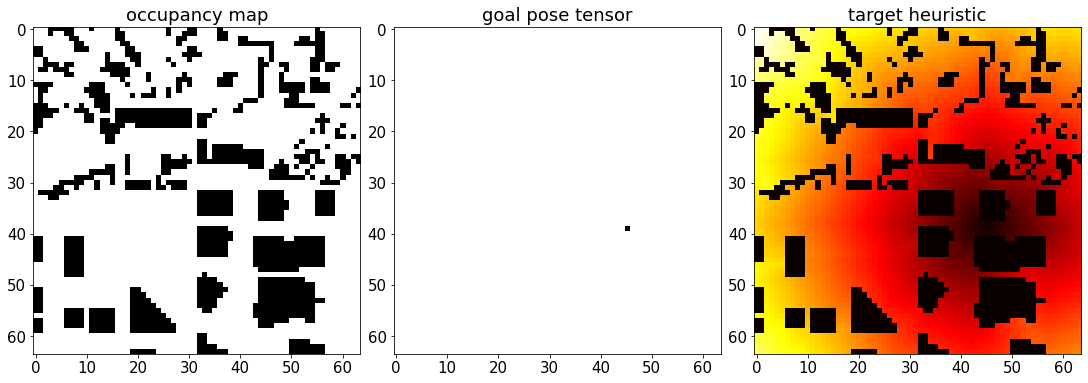

In [25]:
plt.rcParams.update({'font.size': 15})

for i, (X, y) in enumerate(train_loader8):
    if i > 2:
        break
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 15))
    ax1.set_title('occupancy map')
    ax1.imshow(X[0, 0], cmap='gist_yarg')
    ax2.set_title('goal pose tensor')
    ax2.imshow(X[0, 1], cmap='gist_yarg')
    ax3.set_title('target heuristic')
    ax3.imshow(y[0, 0], cmap='hot')

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [27]:
def tanh2val(x):
    """convert a NN's output to the heuristic values"""
    return (x + 1) * SIZE ** 2 / 2

### Learning process

In [28]:
def show_progress(t, fig_name=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 8))
    ax.set_title('loss')
    ax.set_xlabel('time (epochs)')
    ax.set_ylabel('loss')
    ax.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    if fig_name:
        fig.savefig(f'{fig_name}.jpg', bbox_inches='tight')
    plt.show()

In [34]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = tanh2val(model(X))
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if loss.item() < 15 and batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [35]:
def test(epoch, dataloader, model, loss_fn, fig_name=None):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = tanh2val(model(X))
            test_loss += loss_fn(pred, y).item()
    if test_loss / num_batches < 15:
        test_loss /= num_batches
        val_ts.append(epoch+1)
        val_loss.append(test_loss)
        show_progress(epoch+1, fig_name)

### Model

In [36]:
MODEL = 'model'

In [37]:
interval = 10
train_ts, train_loss = [], []
val_ts, val_loss = [], []

def MAELoss(output, target):
    mask = target > -.5
    return torch.mean(torch.abs(output[mask] - target[mask]))

class Model:
    def __init__(self, filename, loss_fn, epochs=200):
        self.loss_fn = loss_fn
        self.epochs = epochs
        fixSeeds(SEED)
        self.net = UnetPlusPlus(
            encoder_name='efficientnet-b2',
            encoder_weights=None,
            in_channels=2,
            activation='tanh'
        ).to(device)
        self.metric = 0
        self.filename=filename
        
    def fit(self, train_loader, val_loader, interval=10):
        optimizer = torch.optim.Adam([
            {'params': self.net.decoder.parameters(), 'lr': 1e-2},
            {'params': self.net.encoder.parameters(), 'lr': 1e-3},
        ])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.epochs)
        
        global train_ts, train_loss
        global val_ts, val_loss
        train_ts, train_loss = [], []
        val_ts, val_loss = [], []
        for t in trange(self.epochs):
            train(t, train_loader, self.net, self.loss_fn, optimizer)
            test(t, val_loader, self.net, self.loss_fn, self.loss_fn.__name__ if t == self.epochs - 1 else None)
            scheduler.step()
        torch.save(self.net.state_dict(), os.path.join(MODEL, filename))
            
    def predict(self, X):
        self.net.eval()
        with torch.no_grad():
            pred = tanh2val(self.net(X))
        return pred

In [38]:
ModelMAE8 = Model('model.pt', MAELoss)
ModelMAE8.fit(train_loader8, val_loader8)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

epoch: 0, batch: 1/1, train loss: 2403.786376953125


  0%|▏                                          | 1/200 [00:07<24:53,  7.50s/it]

epoch: 1, batch: 1/1, train loss: 1553.0823974609375


  1%|▍                                          | 2/200 [00:18<30:29,  9.24s/it]


KeyboardInterrupt: 

In [4]:
ModelMAE4 = Model('model_4conn.pt', MAELoss)
ModelMAE4.fit(train_loader4, val_loader4)

NameError: name 'Model' is not defined